# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [93]:
# Optional, if using Google Colab w/ Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)



In [94]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from cv2.typing import MatLike

# modify to where you store your project data including utils.py
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
import utils

cp: ./utils.py and ./utils.py are identical (not copied).


In [95]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib inline
import matplotlib.pyplot as plt


#### 1. The Original Images and Their FFT images

In [96]:
# Function for fourier transform
def fft_mag_log(im: MatLike):
    f = np.fft.fft2(im)
    f = np.fft.fftshift(f)
    return np.log(np.abs(f))


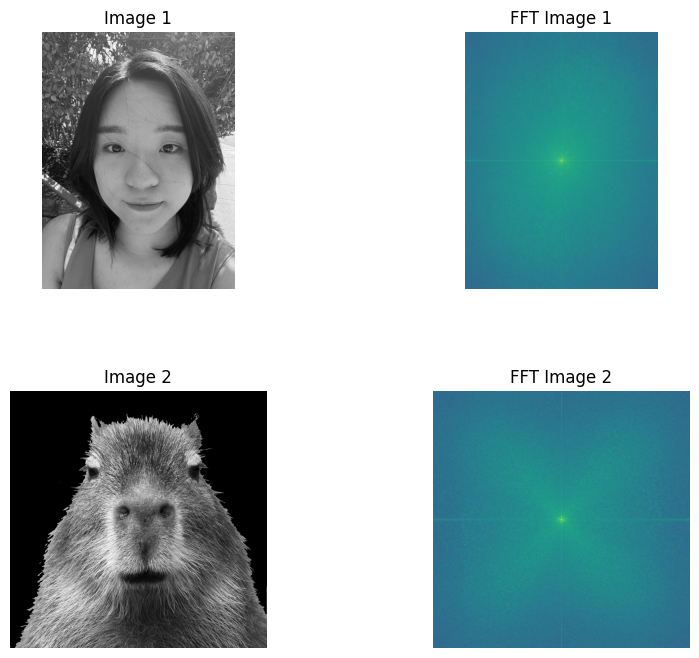

In [97]:
im1_file = datadir + 'photos/vivian.jpg'
im2_file = datadir + 'photos/capybara.png'

# read images in gray scale
im1_grayscale = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2_grayscale = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)
if im1_grayscale is None or im2_grayscale is None:
    exit()

# normalize images
im1 = np.float32(im1_grayscale / 255.0)
im2 = np.float32(im2_grayscale / 255.0)

# FFT images
im1_fft = fft_mag_log(im1) 
im2_fft = fft_mag_log(im2)

# plot the two images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

ax1.imshow(im1, cmap="gray")
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im1_fft)
ax2.set_title("FFT Image 1")
ax2.set_axis_off()

ax3.imshow(im2, cmap="gray")
ax3.set_title("Image 2")
ax3.set_axis_off()

ax4.imshow(im2_fft)
ax4.set_title("FFT Image 2")
ax4.set_axis_off()

#### 2. Image Alignment with Eye Coordinates

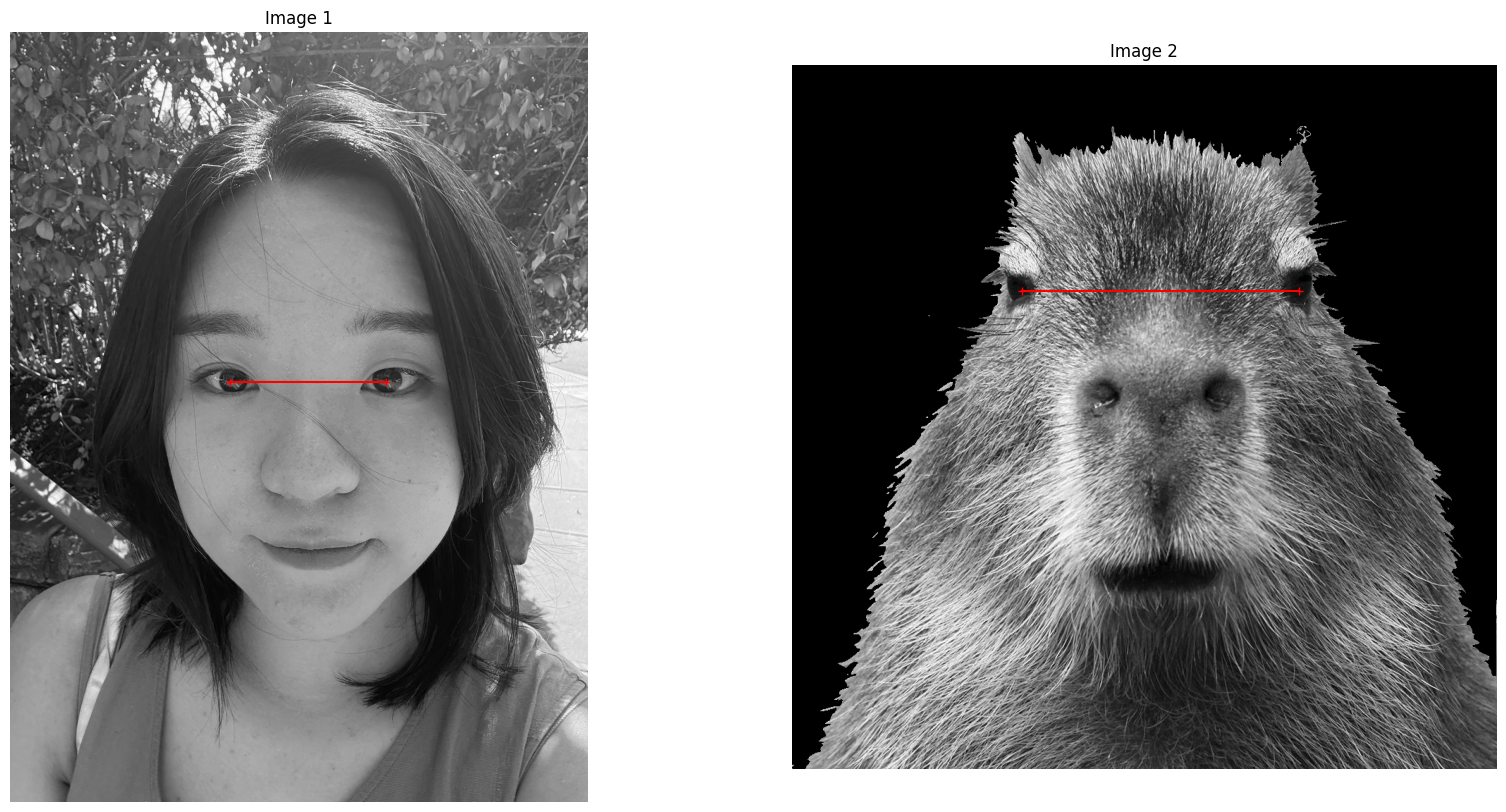

In [98]:
# Fetch the coordinates of eyes in the two images
# set 1: im1: [[422, 670], [721,670]], im2: [[326, 320], [719, 320]]
# set 2: im1: [[820, 400], [970, 410]], im2: [[410, 290], [860, 290]]
# set 3: im1: [[450, 715], [700, 790]], im2: [[405, 390], [600, 390]]

pts_im1 = np.array([[422, 670], [721,670]]) 
pts_im2 = np.array([[326, 320], [719, 320]]) # uncomment if entering [x, y] pts manually

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im1, cmap="gray")
ax1.plot(pts_im1[:, 0], pts_im1[:, 1], 'r-+')
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im2, cmap="gray")
ax2.plot(pts_im2[:, 0], pts_im2[:, 1], 'r-+')
ax2.set_title("Image 2")
ax2.set_axis_off()

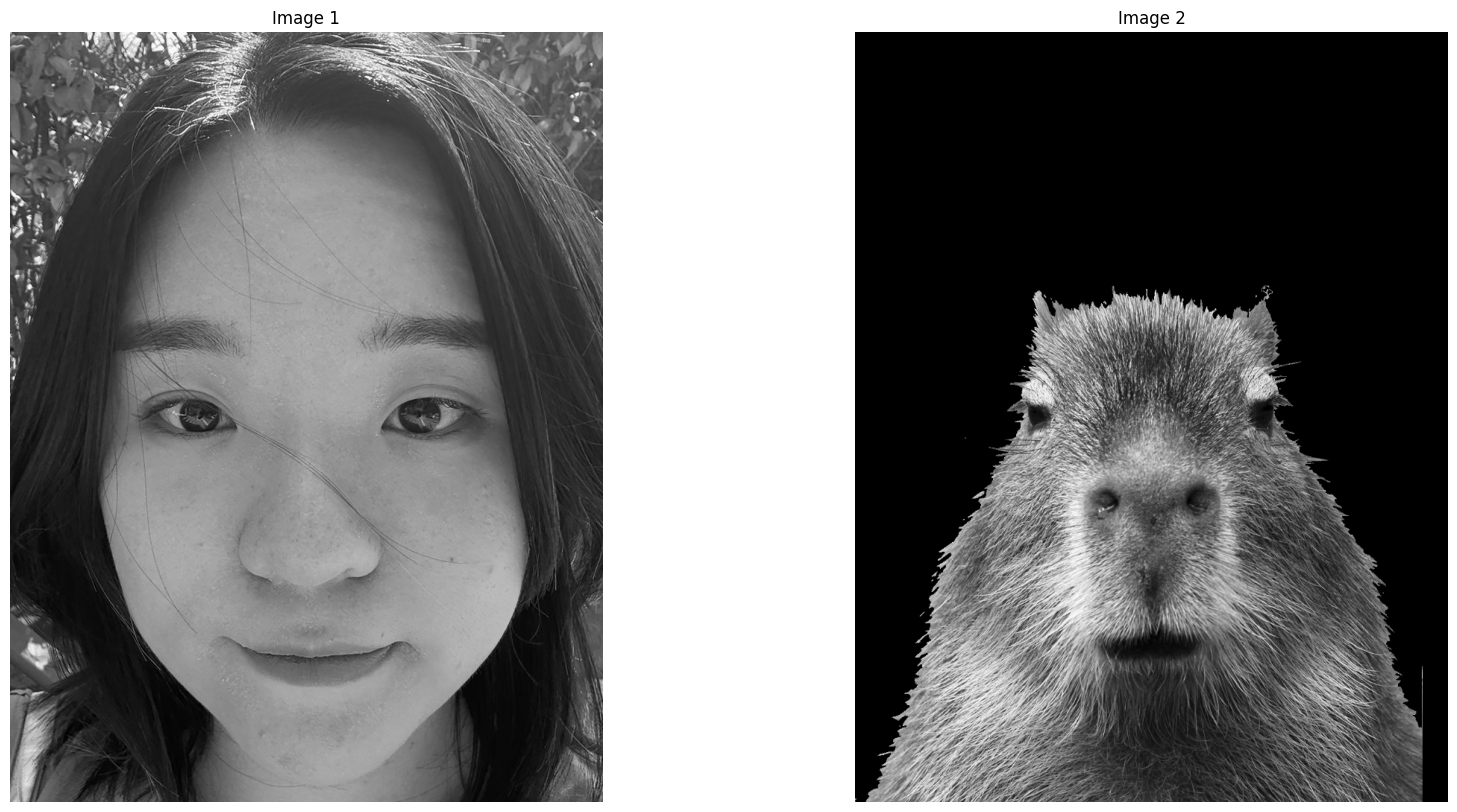

In [99]:
im1_aligned, im2_aligned = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)
# convert to grayscale
im1  = cv2.cvtColor(im1_aligned, cv2.COLOR_BGR2GRAY) / 255.0
im2  = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2GRAY) / 255.0

#Images sanity check
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1')
axes[0].set_axis_off()
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2')
axes[1].set_axis_off()

#### 4. Functions Generating Hybrid Image Filters

In [100]:
def get_2d_gaussian(sigma: int):
    width = 6
    ksize = int(np.ceil(sigma) * width + 1)
    fil = cv2.getGaussianKernel(ksize, sigma)
    fil_2d = fil @ fil.T
    return fil_2d / fil_2d.sum()

def hybridImage(im1: MatLike, im2: MatLike, sigma_low: int, sigma_high: int):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    # filters for im1 and im2
    G_low = get_2d_gaussian(sigma_low)
    G_high = get_2d_gaussian(sigma_high)

    # Apply filters for im1 and im2
    im1_filtered = cv2.filter2D(im1, -1, G_low)
    im2_filtered = im2 - cv2.filter2D(im2, -1, G_high)
    hybrid = im1_filtered + im2_filtered

    return hybrid, im1_filtered, im2_filtered 
      


#### 5. Filtered Images, Hybrid Images, and Their FFT Images

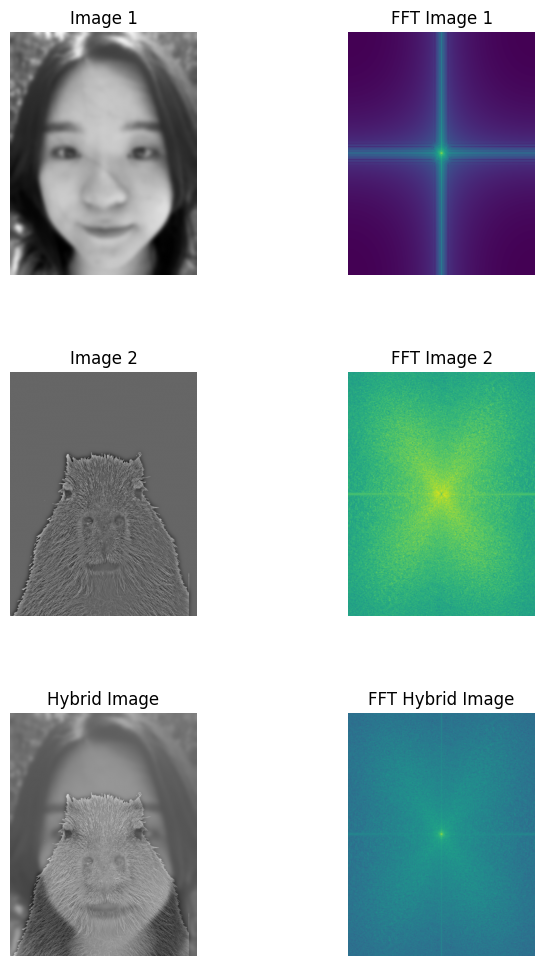

In [101]:
# Create hybrid images set sigmas for hybrid images 
sigma_low = 8 # choose parameters that work for your images
sigma_high = 10 
im_hybrid, im1_filtered, im2_filtered = hybridImage(im1, im2, sigma_low, sigma_high)
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }

# FFT images
im1_filtered_fft = fft_mag_log(im1_filtered)
im2_filtered_fft = fft_mag_log(im2_filtered)
im_hybrid_filtered_fft = fft_mag_log(im_hybrid)

# plot the two images
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)

ax1.imshow(im1_filtered, cmap="gray")
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im1_filtered_fft)
ax2.set_title("FFT Image 1")
ax2.set_axis_off()

ax3.imshow(im2_filtered, cmap="gray")
ax3.set_title("Image 2")
ax3.set_axis_off()

ax4.imshow(im2_filtered_fft)
ax4.set_title("FFT Image 2")
ax4.set_axis_off()

ax5.imshow(im_hybrid, cmap="gray")
ax5.set_title("Hybrid Image")
ax5.set_axis_off()

ax6.imshow(im_hybrid_filtered_fft)
ax6.set_title("FFT Hybrid Image")
ax6.set_axis_off()

#### 6. Visualize Fourier Domain with Annulus

In [ ]:
from matplotlib.patches import Circle, Wedge  

def frac_to_omega(frac):
    return np.clip(frac, 0.0, 1.0) * np.pi

def _parse_band(cut, is_low: bool=True):
    """
    cut can be:
      - None
      - float (fraction of Nyquist if use_fraction else radians)
      - (lo, hi) tuple in same units
    Returns (w_lo, w_hi) in radians/sample or None.
    """
    if cut is None:
        return None
    if isinstance(cut, (tuple, list)):
        lo, hi = cut
    else:
        lo, hi = (0.0, cut) if is_low else (cut, 1.0)

    lo, hi = frac_to_omega(lo), frac_to_omega(hi)
    lo = float(np.clip(lo, 0.0, np.pi))
    hi = float(np.clip(hi, 0.0, np.pi))
    if hi <= lo:  # invalid band
        return None
    return (lo, hi)

def concentric_grid(ax, n=6, color='cyan'):
    for i in range(1, n+1):
        r = (i/n)*np.pi
        ax.add_patch(Circle((0,0), r, fill=False, color=color, alpha=0.7, lw=0.8, transform=ax.transData))

def _shade_annulus(ax, w_lo, w_hi, color='orangered'):
    """
    Shade a full 360° annulus between w_lo and w_hi in ω-coordinates using a Wedge with 'width'.
    """
    if w_hi <= w_lo: 
        return
    # Wedge radius = outer; width = thickness = w_hi - w_lo
    ann = Wedge(center=(0,0), r=w_hi, theta1=0, theta2=360, width=(w_hi - w_lo),
                color=color, alpha=0.18, transform=ax.transData)
    ax.add_patch(ann)
    # Outline boundaries
    ax.add_patch(Circle((0,0), w_lo, fill=False, color=color, lw=2.0, transform=ax.transData))
    ax.add_patch(Circle((0,0), w_hi, fill=False, color=color, lw=1.2, linestyle='--', transform=ax.transData))

def show_fft_with_bands(im, title, lp_cut=None, hp_cut=None, use_fraction=True, n_rings=6,
                        shade_bands=True, lp_color='deepskyblue', hp_color='orangered'):
    """
    img: low-pass, high-pass, or hybrid (spatial-domain image)
    lp_cut / hp_cut:
      - float => fraction of Nyquist (if use_fraction) or radians (if False)
      - tuple(lo, hi) => band in same units
    Shade and/or draw boundary circles for LP [w_lo,w_hi] and HP [w_lo,w_hi].
    """
    spec = fft_mag_log(im)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(spec, cmap='gray', origin='upper', extent=[-np.pi, np.pi, np.pi, -np.pi])
    ax.set_title(title); ax.set_xlabel(r'$\omega_x$'); ax.set_ylabel(r'$\omega_y$')
    ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    ax.set_xticks(ticks); ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_yticks(ticks); ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_aspect('equal', adjustable='box')

    concentric_grid(ax, n=n_rings)

    # Resolve bands (in radians)
    lp_band = _parse_band(lp_cut, is_low=True)
    hp_band = _parse_band(hp_cut, is_low=False)

    # Shade first (underlines), then draw labels
    if shade_bands and lp_band is not None:
        _shade_annulus(ax, lp_band[0], lp_band[1], color=lp_color)
    if shade_bands and hp_band is not None:
        _shade_annulus(ax, hp_band[0], hp_band[1], color=hp_color)

    # Legends/cues
    y0 = -0.88*np.pi
    if lp_band is not None:
        ax.text(-0.95*np.pi, y0, f'LP [{lp_band[0]/np.pi:.2f}π, {lp_band[1]/np.pi:.2f}π]', color=lp_color,
                fontsize=8, bbox=dict(facecolor='black', alpha=0.35, pad=2))
        y0 += 0.10*np.pi
    if hp_band is not None:
        ax.text(-0.95*np.pi, y0, f'HP [{hp_band[0]/np.pi:.2f}π, {hp_band[1]/np.pi:.2f}π]', color=hp_color,
                fontsize=8, bbox=dict(facecolor='black', alpha=0.35, pad=2))

    plt.tight_layout(); plt.show()



# --------- one-call convenience for your three images ---------
def visualize_filtered_and_hybrid(lowpass_img, highpass_img, hybrid_img,
                                  lp_cut=0.30, hp_cut=0.60, use_fraction=False,
                                  shade_bands=True):
    """
    lp_cut / hp_cut:
      - number => single cutoff (LP: [0, cut], HP: [cut, π])
      - (lo, hi) => an explicit band
      - interpreted as fraction-of-Nyquist unless use_fraction=False (then radians)
    """
    show_fft_with_bands(lowpass_img, 'FFT of Low-pass image',
                        lp_cut=lp_cut, hp_cut=None, use_fraction=use_fraction, shade_bands=shade_bands)
    show_fft_with_bands(highpass_img, 'FFT of High-pass image',
                        lp_cut=None, hp_cut=hp_cut, use_fraction=use_fraction, shade_bands=shade_bands)
    show_fft_with_bands(hybrid_img, 'FFT of Hybrid image',
                        lp_cut=lp_cut, hp_cut=hp_cut, use_fraction=use_fraction, shade_bands=shade_bands)

In [ ]:
def db_to_linear(db):
    return 10.0**(db/20.0)

def gaussian_lp_cut_omega(sigma, target_db=-3.0):
    """Low-pass cutoff ω where |G(ω)| hits target_db (e.g., -3 dB)."""
    g = db_to_linear(target_db)  # magnitude target in [0,1]
    return np.sqrt(-2.0*np.log(g)) / float(sigma)

def gaussian_hp_lower_omega(sigma, target_db=-3.0):
    """High-pass lower bound ω where HP gain hits target_db (relative to 1)."""
    g = db_to_linear(target_db)  # e.g., 1/sqrt(2)
    return np.sqrt(-2.0*np.log(1.0 - g)) / float(sigma)

def omega_to_fraction_of_nyquist(omega):
    return float(np.clip(omega, 0.0, np.pi)) / np.pi

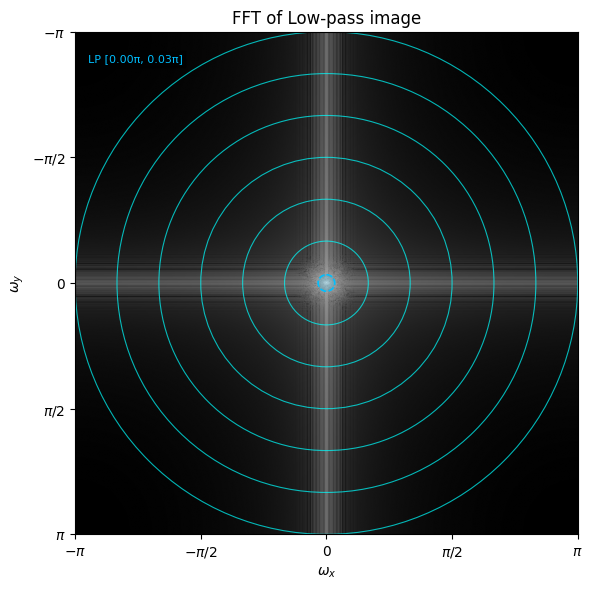

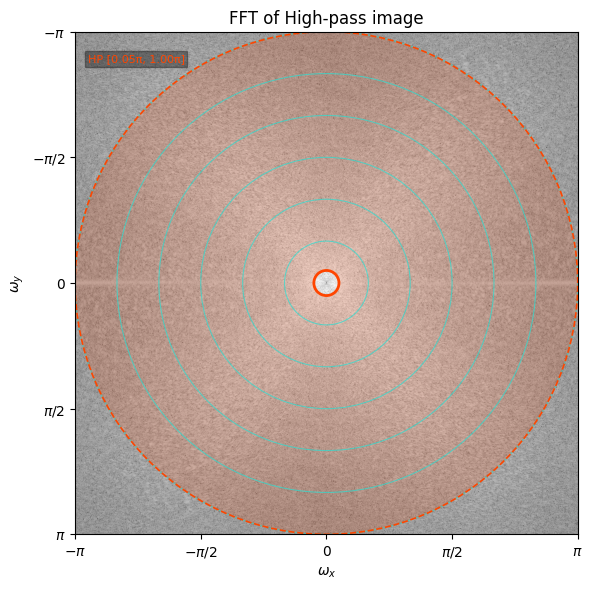

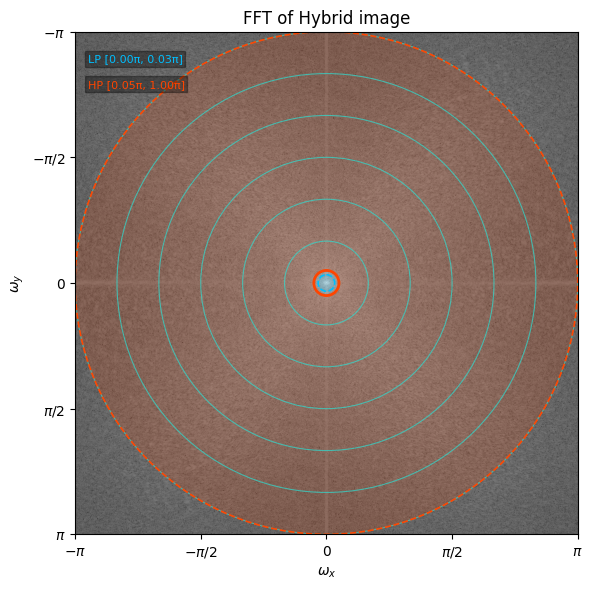

In [103]:
w_lp = gaussian_lp_cut_omega(sigma_low, -3.0)
w_hp = gaussian_hp_lower_omega(sigma_high, -3.0)

lp_cut_frac = omega_to_fraction_of_nyquist(w_lp)
hp_cut_frac = omega_to_fraction_of_nyquist(w_hp)

visualize_filtered_and_hybrid(
    im1_filtered, im2_filtered, im_hybrid,
    lp_cut=lp_cut_frac,     
    hp_cut=hp_cut_frac,     
    use_fraction=True,
)

#### 7. Hybrid Image with Color

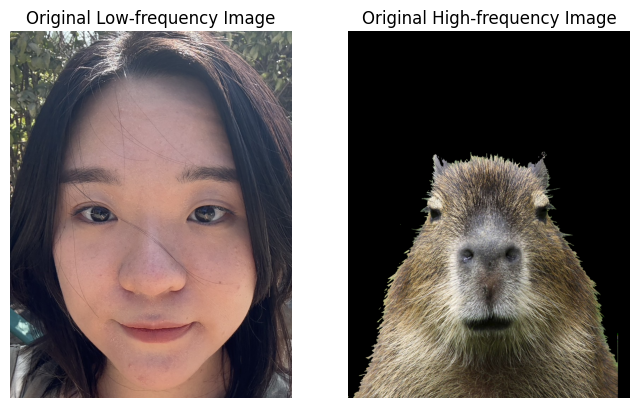

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
ax1.imshow(cv2.cvtColor(im1_aligned, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Low-frequency Image")
ax1.set_axis_off()

ax2.imshow(cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2RGB))
ax2.set_title("Original High-frequency Image")
ax2.set_axis_off()

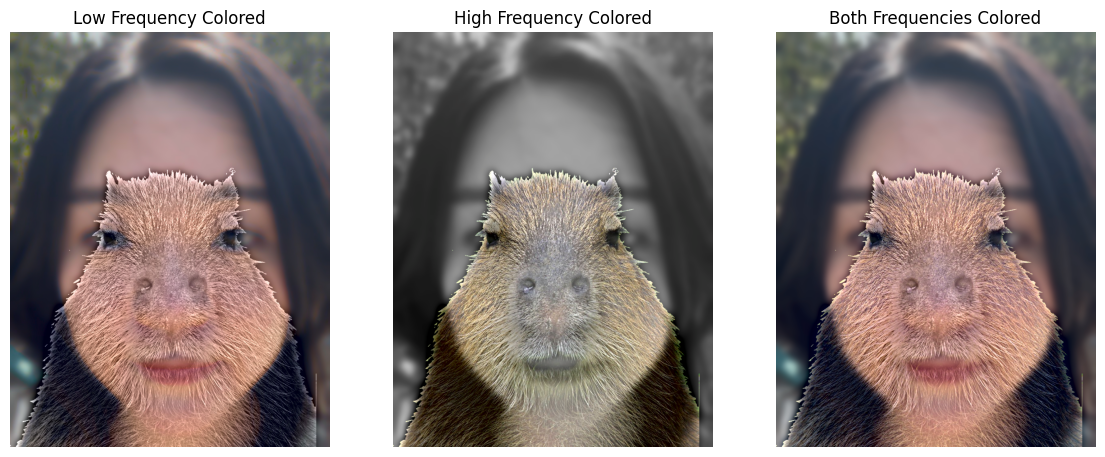

In [105]:
# low frequency images being colored
# 1. Extract lightness channel from im1_alinged and im2_aligned
im1_lab = cv2.cvtColor(im1_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)
L1, a1, b1 = cv2.split(im1_lab)
L2 = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)[:,:,0]

# 2. Generate the hybrid image
hybrid, _, _ = hybridImage(L1, L2, sigma_low, sigma_high)
L_comb = np.clip(hybrid , 0, 255)
lab_comb = cv2.merge([L_comb, a1, b1])
hybrid_im_low_colored = cv2.cvtColor(lab_comb.astype(np.uint8), cv2.COLOR_LAB2RGB)

# high frequency image being colored
# 1. Extract lightness channel from im1_alinged and im2_aligned
im2_lab = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)
L2, a2, b2 = cv2.split(im2_lab)
L1 = cv2.cvtColor(im1_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)[:, :, 0]

# 2. Generate the hybrid image
hybrid, _, _ = hybridImage(L1, L2, sigma_low, sigma_high)
L_comb = np.clip(hybrid, 0, 255)
lab_comb = cv2.merge([L_comb, a2, b2])
hybrid_im_high_colored = cv2.cvtColor(lab_comb.astype(np.uint8), cv2.COLOR_LAB2RGB)

# both frequency images being colored
# 1. Extract lightness channel from im1_alinged and im2_aligned
im1_lab = cv2.cvtColor(im1_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)
L1, a1, b1 = cv2.split(im1_lab)
im2_lab = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2LAB).astype(np.float32)
L2, a2, b2 = cv2.split(im2_lab)

# 2. Generate the hybrid image
L_hybrid, _, _ = hybridImage(L1, L2, sigma_low, sigma_high)
a_hybrid, _, _ = hybridImage(a1, a2, sigma_low, sigma_high)
b_hybrid, _, _ = hybridImage(b1, b2, sigma_low, sigma_high)
L_comb = np.clip(L_hybrid, 0, 255).astype(np.uint8)
a_comb = np.clip(a_hybrid, 0, 255).astype(np.uint8)
b_comb = np.clip(b_hybrid, 0, 255).astype(np.uint8)
lab_comb = cv2.merge([L_comb, a_comb, b_comb])
hybrid_im_colored = cv2.cvtColor(lab_comb, cv2.COLOR_LAB2RGB)

# display images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.imshow(hybrid_im_low_colored)
ax1.set_title("Low Frequency Colored")
ax1.set_axis_off()

ax2.imshow(hybrid_im_high_colored)
ax2.set_title("High Frequency Colored")
ax2.set_axis_off()

ax3.imshow(hybrid_im_colored)
ax3.set_title("Both Frequencies Colored")
ax3.set_axis_off()

#### 8. Laplacian and Gaussian Pyramids

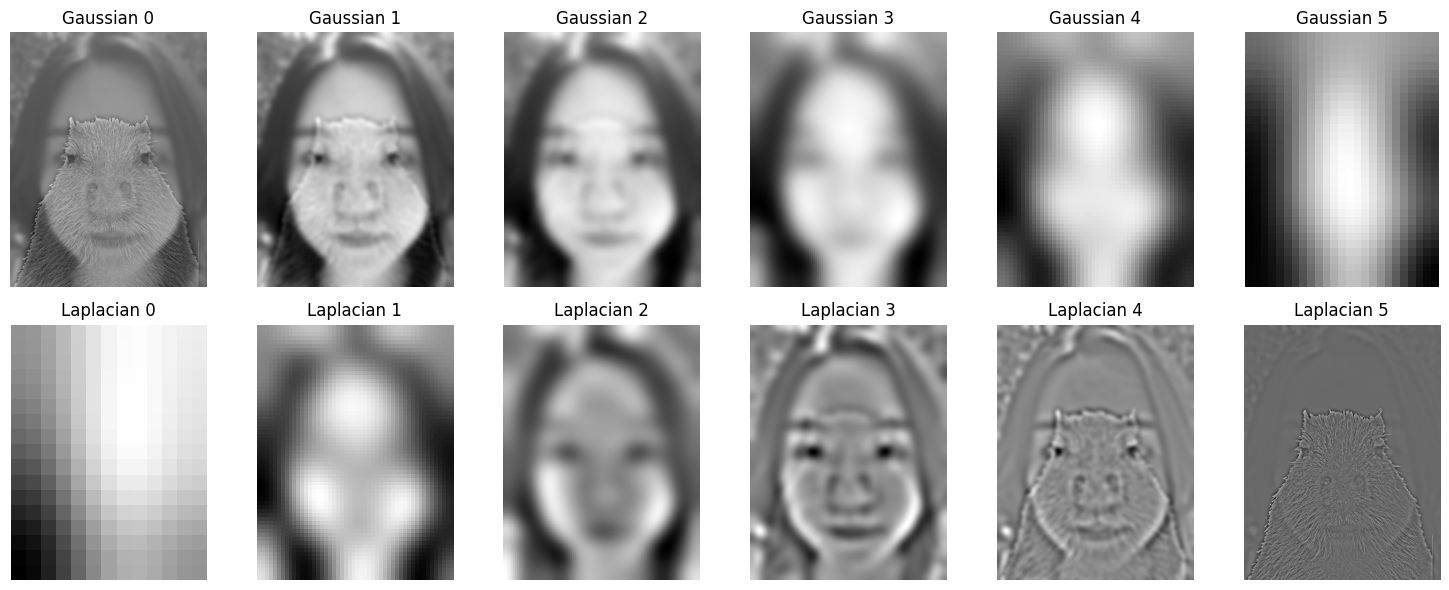

In [117]:
# Gaussian Pyramid 
def gaussian_pyramid(im: MatLike, level: int, sigma: int):
    pyramid = [im]
    for _ in range(level):
        fil = get_2d_gaussian(sigma)
        im_filtered = cv2.filter2D(im, -1, fil) # low-pass filtering
        im = im_filtered[::2, ::2] # down sample by 2 x 2
        pyramid.append(im)
    return pyramid
    
# Laplacian Pyramid
def laplacian_pyramid(gp: list[MatLike], level: int):
    l_pyramid: list[MatLike] = []
    for i in range(level - 1):
        im1 = gp[i]
        im2 = gp[i + 1]

        # up sample 2 x 2
        im1_y, im1_x = im1.shape
        im2 = cv2.resize(im2, (im1_x, im1_y), fx=2, fy=2) 

        # lplacian filterd
        im_filtered = im1 - im2 
        l_pyramid.append(im_filtered)
    l_pyramid.append(gp[-1])
    return l_pyramid


G  = im_hybrid 
level = 6 
gp = gaussian_pyramid(im_hybrid, level, sigma_low)

# Laplacian pyramid
lp = laplacian_pyramid(gp, level)
lp = lp[::-1]

# Visualization
fig, axes = plt.subplots(2, level, figsize=(15,6))

for i in range(level):
    axes[0,i].imshow(gp[i], cmap="gray")
    axes[0,i].set_title(f"Gaussian {i}")
    axes[0,i].axis("off")

    axes[1,i].imshow(lp[i], cmap="gray")
    axes[1,i].set_title(f"Laplacian {i}")
    axes[1,i].axis("off")

plt.tight_layout()
plt.show()


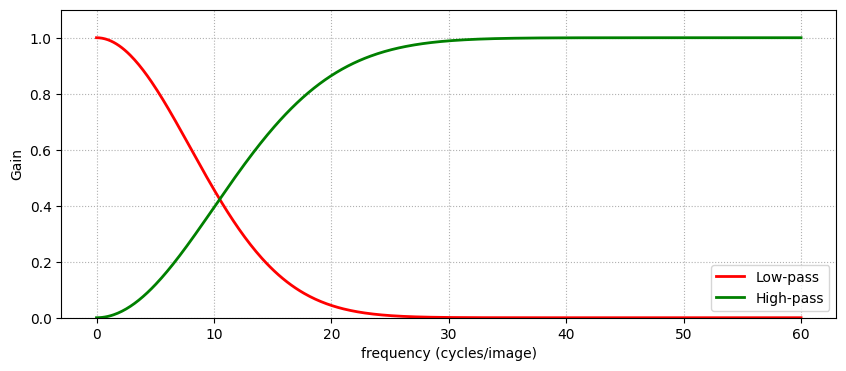

In [107]:
import numpy as np
# Define frequency axis
f = np.linspace(0, 60, 500)  # cycles/image

# Low-pass Gaussian response
H_low = np.exp(-(f**2) / (2 * sigma_low**2))

# High-pass response
H_high = 1 - np.exp(-(f**2) / (2 * sigma_high**2))

# Plot
plt.figure(figsize=(10,4))
plt.plot(f, H_low, 'r', linewidth=2, label="Low-pass")
plt.plot(f, H_high, 'g', linewidth=2, label="High-pass")
plt.xlabel("frequency (cycles/image)")
plt.ylabel("Gain")
plt.ylim(0,1.1)
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

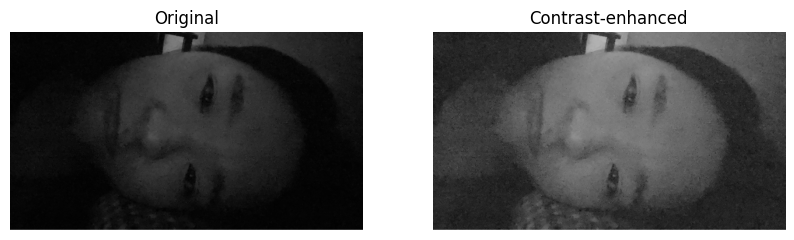

In [118]:
# Read and convert the image to grayscale
contrast_im_file = "photos/contrast_vivian.jpg"
contrast_im = cv2.imread(contrast_im_file, cv2.IMREAD_GRAYSCALE)
if contrast_im is None:
    exit()
contrast_im = np.float32(contrast_im / 255.0) 

# Enhance contrast with gamma function
def enhance_contrast(image, gamma: float):
    return np.power(image, gamma).astype(np.float32)

contrast_im_filtered = enhance_contrast(contrast_im, 0.5)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(contrast_im, cmap="gray")
ax1.set_title("Original")
ax1.set_axis_off()

ax2.imshow(contrast_im_filtered, cmap="gray")
ax2.set_title("Contrast-enhanced")
ax2.set_axis_off()

#### Color enhancement 

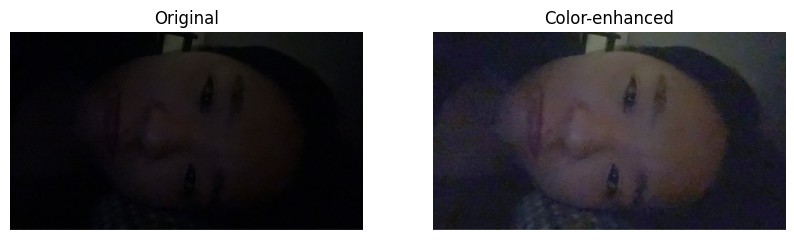

In [ ]:
# Read image and convert color to hsv
color_im_file = "photos/color_vivian.jpg"
color_im = cv2.imread(color_im_file)
if color_im is None:
    exit()

hsv_im = cv2.cvtColor(color_im, cv2.COLOR_BGR2HSV).astype(np.float32)
h, s, v = cv2.split(hsv_im)
def enhance_brightness(hsv: MatLike, gamma: float):
    hsv[:, :, 2] = hsv[:, :, 2] / 255.0
    hsv[:, :, 2] = enhance_contrast(hsv[:, :, 2], gamma)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 1) * 255.0
    return hsv

def enhance_saturation(hsv: MatLike, saturation_factor: float):
    hsv[:, :, 1] = hsv[:, :, 1] / 255.0
    hsv[:, :, 1] = hsv[:, :, 1] * saturation_factor
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 1) * 255.0
    return hsv 

hsv_im = enhance_brightness(hsv_im, 1/2)
hsv_im = enhance_saturation(hsv_im, 0.65)
hsv_u8 = hsv_im.astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title("Original")
ax1.imshow(cv2.cvtColor(color_im, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()

ax2.set_title("Color-enhanced")
ax2.imshow(cv2.cvtColor(hsv_u8, cv2.COLOR_HSV2RGB))
ax2.set_axis_off()

#### Color shift

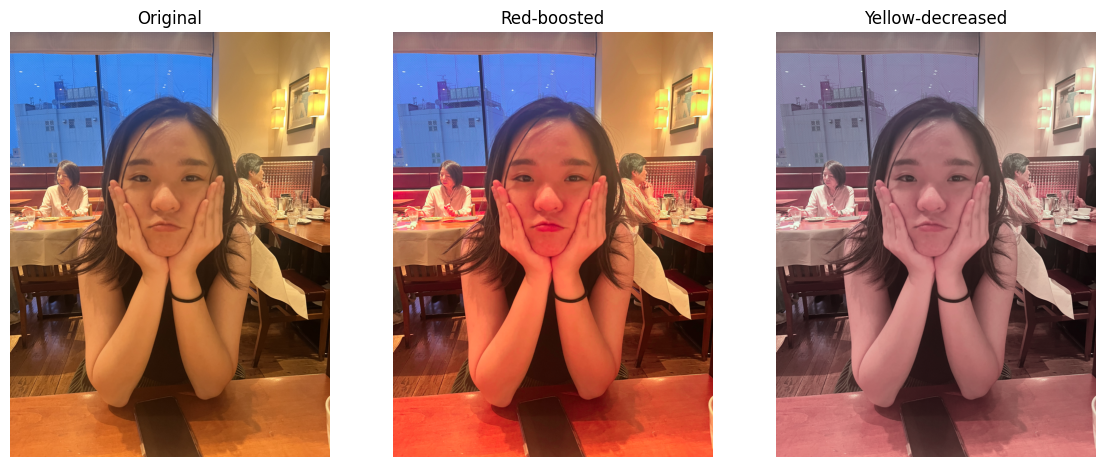

In [110]:
# Helper functiosn for color manipulation 
def manip_color(channel, boost_factor: float):
    # 128: neural color (gray). Deduct it to center the values first
    return np.clip((channel - 128) * boost_factor + 128, 0, 255)

# load images and convert it to the LAB color space
im_path = "photos/color_shift_vivian.jpg"
im = cv2.imread(im_path)
lab_im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB).astype(np.float32)

# separate channels to: lightness, a(green, red), b(blue, yellow)
L, a, b = cv2.split(lab_im)

# boost red
red_boost_factor = 1.8
red_boosted_a = manip_color(a, red_boost_factor)
red_lab_im = cv2.merge([L, red_boosted_a, b]).astype(np.uint8)

# boost yellow
yellow_decrease_factor = 0.3
yellow_decreased_b = manip_color(b, yellow_decrease_factor)
yellow_lab_im = cv2.merge([L, a, yellow_decreased_b]).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.set_title("Original")
ax1.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()
ax2.set_title("Red-boosted")
ax2.imshow(cv2.cvtColor(red_lab_im, cv2.COLOR_LAB2RGB))
ax2.set_axis_off()
ax3.set_title("Yellow-decreased")
ax3.imshow(cv2.cvtColor(yellow_lab_im, cv2.COLOR_LAB2RGB))
ax3.set_axis_off()